In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def plot_gp(mu, cov, X, X_train=None, Y_train=None):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Pred')
    
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx', label='Train samples')
    plt.legend()
    

# $\star$ Question 1:
Load the points from regression.npz. 

Estimate the mean prediction and the variance using a Gaussian process and plot both in the style of last week’s assignment. 

Use an RBF kernel (a Gaussian function). Play
with the hyperparameters (which hyperparameters do you have?) and see
the effect in the predictive distribution. 

Reduce the number of samples and
repeat the experiments.

In [10]:
data = np.load("../data/regression.npz")
train_samples = data["arr_0"]
print(f"Data shape: {train_samples.shape}")

X_train = train_samples[:,0].reshape(-1, 1)
Y_train = train_samples[:,1].reshape(-1, 1)

X_test = np.arange(0.1, 1, 0.05).reshape(-1, 1)

Data shape: (20, 2)


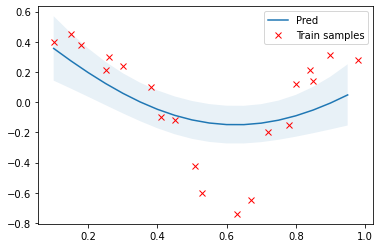

In [11]:
def GP_SCI(X_test, X_train, Y_train, length=1, noise=0.05, sigma_f=1, plot=False):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
    """
    rbf = RBF(length_scale=1)
    gp = GaussianProcessRegressor(kernel=rbf, optimizer=None, alpha=noise)
    gp.fit(X_train, Y_train)
    mu, cov = gp.predict(X_test, return_cov=True)
    plot_gp(mu, cov, X_test, X_train=X_train, Y_train=Y_train)
    
GP_SCI(X_test, X_train, Y_train)

In [23]:
def rbf_kernel(X1, X2, l=1, sigma_f=1):
    """
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
    Returns:
        (m x n) matrix.
    """
    # Note this is an effcient way to compute pairwise distances.
    # Alternatively you can use: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
    # which does the same thing
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


class MyGPRegressor:
    def __init__(self, kernel_fn, beta=100):
        self.kernel_func = kernel_fn 
        self.beta_inv = 1/beta
       
        
    def fit(self, X_train, Y_train):
        """
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        """
        self.C_n = self.kernel_func(X_train, X_train) + self.beta_inv * np.eye(len(X_train))
        self.iC_n = np.linalg.inv(self.C_n)
        self.X_train = X_train
        self.Y_train = Y_train 
    
    def predict(self, X_n):
        X_n = X_n.reshape(-1, 1)
        c = self.kernel_func(X_n, X_n) + self.beta_inv * np.eye(len(X_n)) 
        k = self.kernel_func(self.X_train, X_n) 
    
        mu = k.T.dot(self.iC_n).dot(self.Y_train)
        sigma = c - k.T.dot(self.iC_n).dot(k)
        return mu, sigma 

- Play with the beta parameter of MyGPRegressor and also l and sig_f parameters of rbf_kernel
- Observe how these *hyperparameters* change the data fit. Try to reason why you obtain these different results.

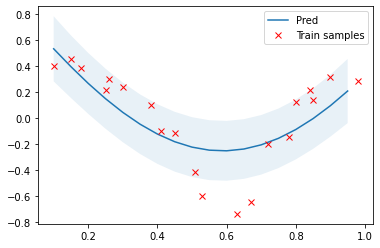

In [43]:
gp = MyGPRegressor(rbf_kernel, beta=80)
gp.fit(X_train, Y_train)

mu_test, sigma_test = gp.predict(X_test)

plot_gp(mu_test, sigma_test, X_test, X_train=X_train, Y_train=Y_train,)


# $\star \star \star$ Question 2:

Can you optimize the hyperparameters? 

You must calculate the gradient of the log-likelihood with respect to each hyperparameter (this requires some knowledge on matrix calculus). 

Once you have the gradient you can run a gradient ascent on the hyperparameters. 

Make sure that the step size in the gradient ascent is not too big, otherwise it will not
converge.

### Hints: You can also use JAX to compute gradients
https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
